# Data Analysis of Images from Lab for measuring speed of light

In [26]:
# import librares 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import altair as alt
from scipy.optimize import curve_fit
import cv2


In [27]:
# declare constants and variables
colors = ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b','#e377c2','#7f7f7f','#bcbd22']

# Measurements
freqs = [0, 66, 200, 284, 372, 491, 639, 783, 908] #rev/s
freqs_rad = [0 for i in range(len(freqs))] #rad/s
for i in range(len(freqs)):
    freqs_rad[i] = freqs[i] * 2 * np.pi
a = 4.94 #m
f = 4.71238 #m
b = 9.564 #m
c = 299792458 #m/s
sigma_w = 6.28 # rad/s
sigma_a = 0.001 # m
sigma_f = 0.001 # m
sigma_b = 0.002 # m
sigma_x = 0.0001 # m

In [28]:
# scan_img_intensity({string} path);
#   Scans an image horizontally, adding up all intensities in each column.
#   Returns an array of intensities mapped to the x within the image.
def scan_img_intensity(path):
    img = cv2.imread(path)
    intensities = [0 for i in range(len(img[0]))]
    for x in range(len(intensities)):
        for y in range(len(img)):
            intensities[x] += img[y][x][0]
        
        # Calibrate 'zero' intensity
        intensities[x] -= 11500
    return intensities

def scan_img_intensity_blur(path):
    img = cv2.imread(path)
    cv2.GaussianBlur(img, (100, 100), 0)
    intensities = [0 for i in range(len(img[0]))]
    for x in range(len(intensities)):
        for y in range(len(img)):
            intensities[x] += img[y][x][0]
        
        # Calibrate 'zero' intensity
        intensities[x] -= 11500
    return intensities

def omega_calculation(C, x, a, f, b):
    return 4 * C * a * (f + b) / x

# gaussian fit
def gaussian(x, A, u, o):
    return A * (1 / (o * np.sqrt(2 * np.pi))) * np.exp(-((x - u) ** 2) / (2 * o ** 2))

# pixels to meters
def pix_to_m(pixels):
    return pixels / (33.75 * 1000)

# lightspeed fit
def lightspeed(x, w):
    return 4 * w * a * (f + b) / x

# percent error
def percent_error(actual_value, estimated_value):
    absolute_error = abs(actual_value - estimated_value)
    relative_error = absolute_error / actual_value
    return relative_error * 100

def partial_w(a, f, b, x):
    return 4 * a * (f + b) / x

def partial_a(w, f, x):
    return 4 * w * f / x

def partial_f(w, a, x):
    return 4 * w * a / x

def partial_b(w, a, x):
    return 4 * w * a / x

def partial_x(w, a, f, b, x):
    return -4 * w * a * (f + b) / (x ** 2)

# Calculate uncertainty in c
def calculate_sigma_c(w, x):
    term1 = (partial_w(a, f, b, x) * sigma_w) ** 2
    term2 = (partial_a(w, f, x) * sigma_a) ** 2
    term3 = (partial_f(w, a, x) * sigma_f) ** 2
    term4 = (partial_b(w, a, x) * sigma_b) ** 2
    term5 = (partial_x(w, a, f, b, x) * sigma_x) ** 2
    return np.sqrt(term1 + term2 + term3 + term4 + term5)


In [29]:
import plotly.graph_objects as go
import numpy as np
from scipy.optimize import curve_fit

# Get x's
trials_raw = [scan_img_intensity('./Imgs/image_' + str(i+1) + '.png') for i in range(9)]
trials_blur = [scan_img_intensity('./Imgs/image_' + str(i+1) + '.png') for i in range(9)]


# Plot intensities of images and gaussian fits
x = np.linspace(0, len(trials_raw[0])-1, len(trials_raw[0]))
means = []
dxs = [] 
dxs_adjusted = [] # 

p0s = [
    [140000, 308, 1], [36000, 328, 1], [36000, 354, 1],
    [36000, 371, 1], [36000, 390, 1], [35500, 416, 1],
    [34000, 449, 1], [32000, 483, 1], [34500, 510, 1]
]

# Create a figure
fig_raw = go.Figure()
fig_fits = go.Figure()


# Plot each trial with its Gaussian fit for raw images
for i, trial in enumerate(trials_raw):
    # Plot trial intensity
    fig_raw.add_trace(go.Scatter(x=x, y=trial, mode='lines', name=f'Trial {i+1}'))

    # Plot Gaussian fit
    popt, pcov = curve_fit(gaussian, x, trial, p0=p0s[i])
    A, u, o = popt
    means.append(u)
    y_gaussian = gaussian(x, A, u, o)
    fig_fits.add_trace(go.Scatter(x=x, y=y_gaussian, mode='lines', name=f'Gaussian Fit {i+1}'))

    # Get dx
    if i > 0:
        dxs.append(pix_to_m(means[i] - means[0]))
        if i > 1:
            dxs_adjusted.append(pix_to_m(means[i] - (means[0] + means[1]) * 0.5))

# Update layout for the plot
fig_raw.update_layout(
    title='Light Intensity vs. X',
    xaxis_title='x(pixels)',
    yaxis_title='Total X Brightness',
    legend_title='Legend',
    hovermode='closest'
)
fig_fits.update_layout(
    title='Light Intensity vs. X',
    xaxis_title='x(pixels)',
    yaxis_title='Total X Brightness',
    legend_title='Legend',
    hovermode='closest'
)

# Show plot
fig_raw.show()
fig_fits.show()

In [30]:
# Plot light speeds adjusted
lspeeds = [0 for i in range(7)]
for i in range(len(lspeeds)):
    lspeeds[i] = lightspeed(dxs_adjusted[i], freqs_rad[i+2])
    print(f"Speed of light for trial {i+1}: {lspeeds[i]} m/s")
lspeed = np.average(lspeeds[1:])

#ae = abs(c - lspeed)
pe = percent_error(c,lspeed)
std = np.std(lspeeds, ddof=1)

# Create a DataFrame for Altair to use
data = pd.DataFrame({
    'x': [dx*1000 for dx in dxs_adjusted for _ in range(2)],
    'v': [lspeed for _ in range(len(dxs_adjusted))] + [c for _ in range(len(dxs_adjusted))],
    'type': ['calculated speed of light' for _ in range(len(dxs_adjusted))] + ['speed of light' for _ in range(len(dxs_adjusted))]
})

# Create error DataFrame
error_data = pd.DataFrame({
    'x': [dx*1000 for dx in dxs_adjusted],
    'v': lspeeds,
    'error': [calculate_sigma_c(freq, dx) for freq, dx in zip(freqs_rad[2:], dxs_adjusted)]
})

# Create the chart
chart = alt.Chart(data).mark_line().encode(
    x='x',
    y='v',
    color='type'
)

# Create error chart
error_chart = alt.Chart(error_data).mark_errorbar(extent='ci').encode(
    x='x',
    y=alt.Y('v', title='v(m/s)'),
    yError='error'
)


# Display the chart and make it interactive
chart + error_chart



Speed of light for trial 1: 311991621.4213261 m/s
Speed of light for trial 2: 310604112.1728303 m/s
Speed of light for trial 3: 306813599.51158935 m/s
Speed of light for trial 4: 294951466.8349556 m/s
Speed of light for trial 5: 288174972.8693394 m/s
Speed of light for trial 6: 283510141.406132 m/s
Speed of light for trial 7: 290115675.7543133 m/s


alt.LayerChart(...)

In [42]:
import plotly.graph_objects as go
import numpy as np
from scipy.optimize import curve_fit

# ... Your previous functions definitions like scan_img_intensity, gaussian, etc ...

# Your experimental data (you'll need to calculate these from your actual data)
means = means  # This should be your list of means from the Gaussian fits
omega_experimental = np.array(freqs_rad)  # Convert frequency to rad/s

# Convert the means to displacements in meters
x_experimental =  dxs_adjusted[1:] # Assuming 1 pixel = pix_to_m(1) meters

# Theoretical omega values based on the exact speed of light
# Using the equation you've provided: omega = 4 * C * a * (f + b) / x
# We rearrange this to solve for x given omega and C (speed of light)
x_theoretical = [4 * c * a * (f + b) / omega for omega in omega_experimental if omega != 0] 

dxs_x_theoretical = [] 
dxs_adjusted_x_theoretical = [] # 

# ajusted x_theroetical values
for i in range(len(x_theoretical)):
    # Get dx
    if i > 0:
        dxs_x_theoretical.append(pix_to_m(means[i] - means[0]))
        if i > 1:
            dxs_adjusted_x_theoretical.append(pix_to_m(means[i] - (means[0] + means[1]) * 0.5))

# Create a plot
fig = go.Figure()

# Add the experimental data line
fig.add_trace(go.Scatter(x=x_experimental, y=omega_experimental[1:], mode='lines+markers', name='Experimental'))

# Add the theoretical data line (as a straight horizontal line at c, the speed of light)
fig.add_trace(go.Scatter(x=dxs_adjusted_x_theoretical, y=omega_experimental[1:], mode='lines', name='Theoretical'))

# Update layout for the plot
fig.update_layout(
    title='Experimental vs Theoretical Omega as a function of X',
    xaxis_title='X Displacement (m)',
    yaxis_title='Omega (rad/s)',
    legend_title='Legend'
)

# Show plot
fig.show()


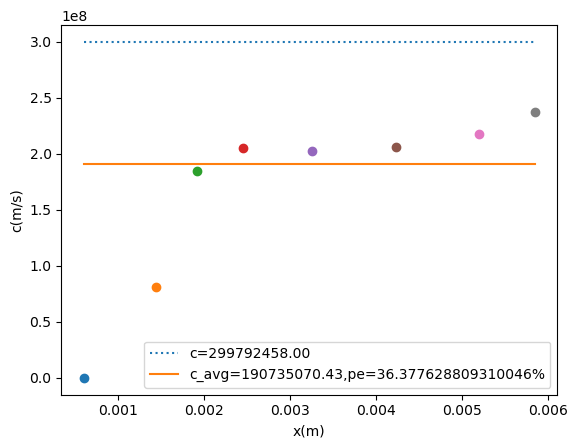

In [32]:

# Plot light speeds
lspeeds = [0 for i in range(8)]
for i in range(len(lspeeds)):
    lspeeds[i] = lightspeed(dxs[i], freqs_rad[i])
    plt.scatter(dxs[i], lspeeds[i])
lspeed = np.average(lspeeds[1:])
plt.plot([dxs[0], dxs[len(dxs)-1]],[c,c],linestyle='dotted',label='c='+f"{c:.2f}")
plt.plot([dxs[0], dxs[len(dxs)-1]],[lspeed,lspeed],label='c_avg='+f"{lspeed:.2f}"+\
         f',pe={percent_error(c,lspeed)}%')
plt.legend()
plt.xlabel('x(m)')
plt.ylabel('c(m/s)')
plt.show()

# DASH
### link: http://127.0.0.1:8050/

In [33]:
from dash import Dash, html, dcc, callback, Output, Input
import plotly.express as px
import pandas as pd
import altair as alt
import dash_vega_components as dvc


app = Dash(__name__)

app.layout = html.Div([
    html.H1(children='NBA Wins Analysis', style={'textAlign':'center'}),
    html.Div(children='  ', style={'textAlign':'center'}),

    # for plotly express graphs
    dcc.Graph(
        id='graph-perc_over_time_wins_chart',
        figure=perc_over_time_wins_chart
    ),
    # for vega-lite graphs
    dvc.Vega(
        id='graph-content-attendance_chart',
        opt={},
        spec=attendance_chart.to_dict()
    ),

    dcc.Graph(
        id='graph-PF_vs_DE_Team_chart',
        figure=PF_vs_DE_Team_chart
    ),

    dvc.Vega(
        id='graph-content-combined_charts_stats',
        opt={},
        spec=combined_charts_stats.to_dict()
    ),

    dvc.Vega(
        id='graph-content-height_chart',
        opt={},
        spec=height_chart.to_dict()
    ),

    dcc.Graph(
        id='graph-avg_team_age_vs_wins_reg_chart',
        figure=avg_team_age_vs_wins_reg_chart
    ),
   

    dvc.Vega(
        id='graph-content-model_performance',
        opt={},
        spec=model_performance.to_dict()
    )


])

@callback(
    Output('graph-content-combined_charts_stats', 'spec'),
    Input('year-slider', 'value')
)
def update_graph(value):
    return slider_selection.update(value=value)

if __name__ == '__main__':
    app.run(debug=True)

NameError: name 'perc_over_time_wins_chart' is not defined